# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

## Setting up network and loading weights

In [2]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

## Loading the test image and preprocessing

In [4]:
image_path = "../ff.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

In [5]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]
print(type(disp))
print(disp.shape)
print(disp)

<class 'torch.Tensor'>
torch.Size([1, 1, 192, 640])
tensor([[[[0.1782, 0.1781, 0.1781,  ..., 0.1977, 0.1984, 0.1988],
          [0.1785, 0.1785, 0.1782,  ..., 0.1996, 0.2000, 0.2003],
          [0.1793, 0.1791, 0.1791,  ..., 0.1993, 0.1995, 0.1998],
          ...,
          [0.6403, 0.6399, 0.6394,  ..., 0.5324, 0.5347, 0.5370],
          [0.6450, 0.6444, 0.6441,  ..., 0.5373, 0.5396, 0.5423],
          [0.6482, 0.6479, 0.6468,  ..., 0.5413, 0.5439, 0.5465]]]])


## Plotting

[[0.1782167 0.1782167 0.1782167 ... 0.1988474 0.1988474 0.1988474]
 [0.1782167 0.1782167 0.1782167 ... 0.1988474 0.1988474 0.1988474]
 [0.1782167 0.1782167 0.1782167 ... 0.1988474 0.1988474 0.1988474]
 ...
 [0.6482376 0.6482376 0.6482376 ... 0.5465276 0.5465276 0.5465276]
 [0.6482376 0.6482376 0.6482376 ... 0.5465276 0.5465276 0.5465276]
 [0.6482376 0.6482376 0.6482376 ... 0.5465276 0.5465276 0.5465276]]


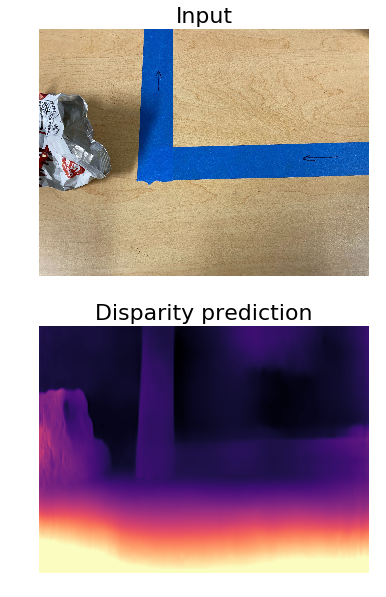

In [6]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)


# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
print(disp_resized_np)
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

In [7]:
disp_resized_np_after_rescaling = np.multiply(disp_resized_np, original_width)
print(disp_resized_np_after_rescaling)

[[ 718.5697  718.5697  718.5697 ...  801.7527  801.7527  801.7527]
 [ 718.5697  718.5697  718.5697 ...  801.7527  801.7527  801.7527]
 [ 718.5697  718.5697  718.5697 ...  801.7527  801.7527  801.7527]
 ...
 [2613.6938 2613.6938 2613.6938 ... 2203.5994 2203.5994 2203.5994]
 [2613.6938 2613.6938 2613.6938 ... 2203.5994 2203.5994 2203.5994]
 [2613.6938 2613.6938 2613.6938 ... 2203.5994 2203.5994 2203.5994]]


In [9]:
baseline = 0.54
focal = 707.0493
prod = baseline*focal
depth_in_meters = np.divide(prod, disp_resized_np_after_rescaling)
print(depth_in_meters[1441][122])
print(depth_in_meters[489][1587])

0.29193747
0.5257926
